<a href="https://colab.research.google.com/github/jhmendonca/stablediffusion/blob/main/Diffusers_Treinamento_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VAE — Variational Auto Encoder**

Um codificador automático contém duas partes.

1. Toma uma imagem como entrada e a converte em uma representação
latente de baixa dimensão.

2. Pega a representação latente e a converte de volta em uma imagem.

![](https://huggingface.co/jhmendonca/stablediffusion-webui/resolve/main/latente_imagem.png)

Como podemos ver acima, o Encoder funciona como um compressor que esmaga a imagem em dimensões mais baixas e o decodificador recria a imagem original de volta da versão compactada.

Vamos começar a analisar o VAE através do código. Começaremos importando as bibliotecas necessárias e algumas funções auxiliares.

In [ ]:
!pip install -qq -U transformers diffusers accelerate
## To import an image from a URL
from fastdownload import FastDownload
## Imaging  library
from PIL import Image
from torchvision import transforms as tfms
## Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
## Loading a VAE model
from diffusers import AutoencoderKL


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.0 MB/s eta 0:00:00


In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

def load_image(p):
   ## Function to load images from a defined path
   return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    ##Function to convert image to latents
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    ##Function to convert latents to images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

Vamos baixar uma imagem da internet.

Dimension of this image: (512, 512, 3)


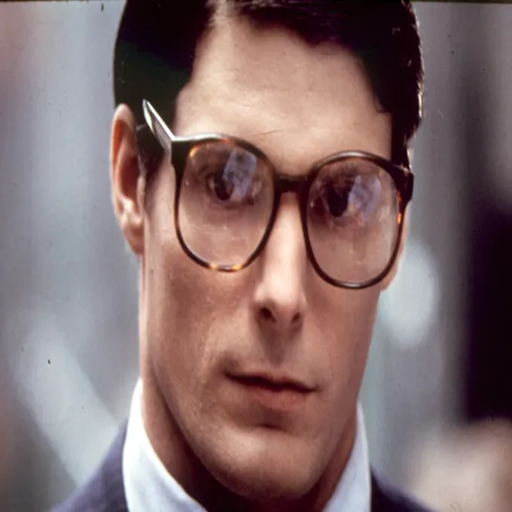

In [ ]:
p = FastDownload().download('https://saude.abril.com.br/wp-content/uploads/2017/01/christopher-reeve-super-homem.jpg?quality=85&strip=info&w=680&h=453&crop=1')
img = load_image(p)
print(f"Dimension of this image: {np.array(img).shape}")
img

Agora vamos compactar essa imagem usando o codificador VAE, vamos usar a function pil_to_latents

In [ ]:
latent_img = pil_to_latents(img)
print(f"Dimension of this latent representation: {latent_img.shape}")

Dimension of this latent representation: torch.Size([1, 4, 64, 64])


Como podemos ver como o VAE compactou uma imagem de dimensão 3 x 512 x 512 em uma imagem de 4 x 64 x 64.Vamos visualizar esses quatro canais de representações latentes.

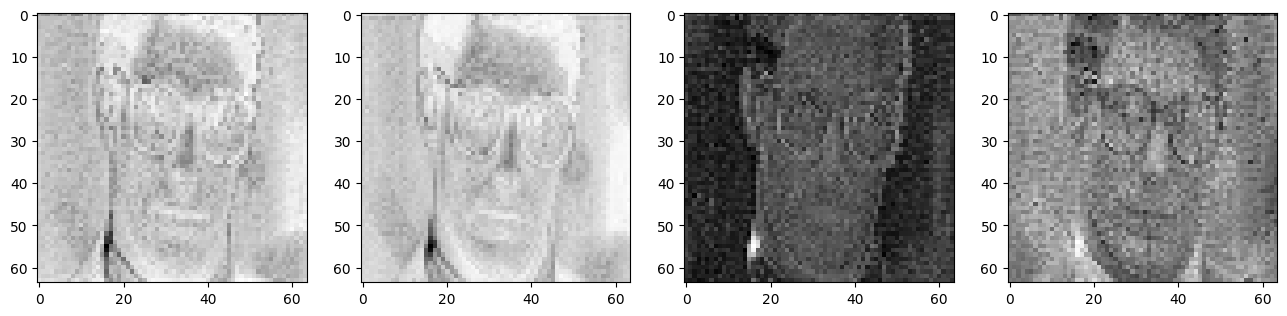

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu(), cmap='Greys')

Essa representação latente, em tese, deveria capturar muitas informações sobre a imagem original. Vamos usar o decodificador nesta representação para ver o que recebemos de volta. Para isso, usaremos a função latents_to_pil

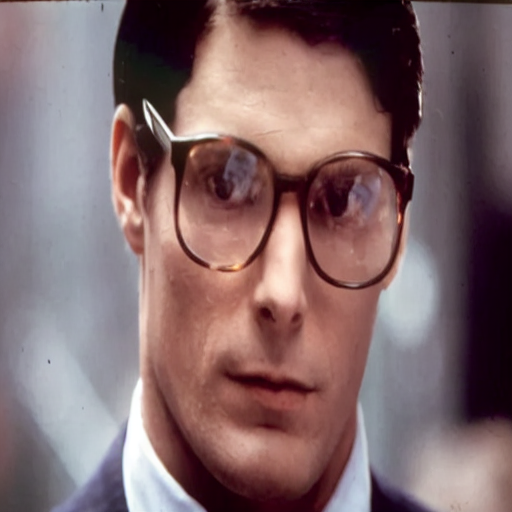

In [ ]:
decoded_img = latents_to_pil(latent_img)
decoded_img[0]